<a href="https://colab.research.google.com/github/nikita-0209/matching-matched-filter/blob/master/DL_Matched_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
import numpy as np

In [0]:
from numpy.random import uniform

In [0]:
import pandas as pd

In [0]:
# !pip install lalsuite

In [0]:
# import sys
# !{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

In [0]:
import pylab

In [0]:
import pycbc

# Data From Injection File

In [0]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

In [0]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [0]:
# #Dataset
# downloaded = drive.CreateFile({'id':"1SP57td6q9PCVJuJ8t448DrEmyu6_2Wcz"})   # replace the id with id of file you want to access
# downloaded.GetContentFile('injection_data.xlsx')        # replace the file name with your file

In [0]:
# #Dataset
# downloaded = drive.CreateFile({'id':"1EJ-ADIY2MSBu6DHR3m843DKRcFTL-HKT"})   # replace the id with id of file you want to access
# downloaded.GetContentFile('distance_injections.xlsx')        # replace the file name with your file

In [0]:
signal_data=pd.read_excel('injection_data.xlsx', names=['mass1', 'mass2', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'geocent_time'] )

In [0]:
distance_data=pd.read_excel('distance_injections.xlsx', names=['distance', 'SNR'] )

In [0]:
signal_data.head(10)

,mass1,mass2,luminosity_distance,dec,ra,theta_jn,psi,phase,geocent_time
0,34.769382,22.067648,100,0.476743,0.865509,0.089244,2.236250,1.207492,-0.036691
1,52.264753,26.920606,100,0.802188,0.205857,2.124343,0.427505,5.474731,0.028464
2,24.031573,17.698322,100,0.643144,5.234487,1.717964,0.093129,2.240526,0.060359
3,59.616037,32.912266,100,1.181200,0.684888,2.116541,0.769792,4.331894,-0.045774
4,31.965274,11.421382,100,1.106890,0.800020,1.114848,2.553226,4.168019,-0.034635
5,49.020917,18.664094,100,-1.268530,3.384477,0.919404,1.853104,4.533653,-0.005067
6,49.635037,28.981642,100,1.011487,4.724171,2.683427,2.898480,1.587583,-0.053270
7,64.050693,11.318849,100,0.428512,3.998504,1.718629,0.283543,5.109386,0.029129
8,33.260962,8.601422,100,0.917346,1.713397,1.829735,1.072181,2.749452,-0.052606
9,50.527195,47.793341,100,-0.526689,1.789146,2.502245,2.283553,0.919675,-0.089908


In [0]:
distance_data.head()

,distance,SNR
0,2474.272753,6.0
1,2482.375371,6.0
2,1157.223082,6.0
3,2529.076369,6.0
4,1061.410622,6.0


In [0]:
N=8192*100  #N is number of samples, N=length/delta_t
fs=8192 #fs is sampling frequnecy
length=100 #duration of segment
delta_f=fs/N
f_samples = N/ 2 + 1
f_lower=20
delta_t=1.0/8192

In [0]:
from pycbc.psd.analytical import AdVDesignSensitivityP1200087

def get_psd(f_samples, delta_f, low_freq_cutoff):
  psd=AdVDesignSensitivityP1200087(f_samples, delta_f, low_freq_cutoff)
  return psd

In [0]:
from pycbc.noise.gaussian import frequency_noise_from_psd

def get_noise(psd, seed=None):
  noise=frequency_noise_from_psd(psd, seed=seed)
  noise_time = noise.to_timeseries()
  return noise_time

In [0]:
def get_data(data, dist):
    m1=data['mass1']
    m2=data['mass2']
    dec=data['dec']
    ra=data['ra']
    inclination=data['theta_jn']
    coa_phase=data['phase']
    pol_angle=data['psi']
    distance=dist['distance']
    return m1, m2, dec, ra, inclination, coa_phase, pol_angle, distance

In [0]:
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

def get_signal(m1, m2, dec, ra, inclination, coa_phase, pol_angle, distance, delta_t, f_lower):
  apx = 'IMRPhenomD'
  hp, hc = get_td_waveform(approximant=apx,
                                 mass1=m1,
                                 mass2=m2,
                                 spin1z=0,
                                 delta_t=delta_t,
                                 distance=distance,
                                 inclination = inclination,
                                 coa_phase =  coa_phase,
                                 f_lower=f_lower)
  
  det_h1 = Detector('H1')
  signal = det_h1.project_wave(hp, hc, ra, dec, pol_angle)
  signal_peak_index=np.argmax(signal)

  return signal, signal_peak_index


In [0]:
def add_noise_signal(noise, signal):
  length_signal = len(signal)
  signal_plus_noise=noise
  signal_plus_noise[0:length_signal]=np.add(noise[0:length_signal], signal)
  return signal_plus_noise

In [0]:
from pycbc.psd import welch, interpolate

def get_whiten(signal_plus_noise):
  signal_freq_series=signal_plus_noise.to_frequencyseries()
  numerator = signal_freq_series
  psd_to_whiten = interpolate(welch(signal_plus_noise), 1.0 / signal_plus_noise.duration)
  denominator=np.sqrt(psd_to_whiten)
  whiten_freq = (numerator / denominator)
  whiten=whiten_freq.to_timeseries()
  return whiten

In [0]:
def get_1s(whiten, signal_peak_index=None):
  
  if signal_peak_index==None:
    zoom=whiten.time_slice(0,1)
    return zoom.data.reshape((8192, 1))

  max_index=signal_peak_index+2
  time_of_max=whiten.sample_times.data[max_index]
  if time_of_max>0.8:
    zoom = whiten.time_slice(time_of_max-0.8, time_of_max+0.2)
  elif time_of_max>0.6:
    zoom = whiten.time_slice(time_of_max-0.6, time_of_max+0.4)
  return zoom.data.reshape((8192, 1))

In [0]:
psd=get_psd(f_samples, delta_f, f_lower)

/usr/local/lib/python3.6/dist-packages/pycbc/psd/analytical.py:103: RuntimeWarning: forcing length argument to int
  warnings.warn('forcing length argument to int', RuntimeWarning)


##  Preparing Training Dataset

In [0]:
signal_num=signal_data.shape[0]//4  #number of samples considered
i=0

In [0]:
noise_seeds=[44, 76, 32]  

In [0]:
total=signal_num*len(noise_seeds)

In [0]:
X=np.zeros((total*2,8192, 1))
# timeseries=np.zeros((len(total),8192))

In [0]:
for i in range(0, total):
  noise=get_noise(psd)
  whiten = get_whiten (noise)
  X[i] =  get_1s (whiten)

In [0]:
i=7499

In [0]:
total

7500

In [0]:
for index in range (0, total):
# for index in total:
  m1, m2, dec, ra, inclination, coa_phase, pol_angle, distance = get_data (signal_data.loc[index], distance_data.loc[index] )
  signal, signal_peak_index = get_signal(m1, m2, dec, ra, inclination, coa_phase, pol_angle, distance, delta_t, f_lower)
  i=i+1
  for seed in noise_seeds:
    noise=get_noise(psd, seed)
    final = add_noise_signal(noise, signal)
    whiten = get_whiten (final)
    X[i] =  get_1s (whiten, signal_peak_index)

In [0]:
X.shape

(15000, 8192, 1)

# Read the X Samples

In [0]:
file_name='/content/drive/My Drive/Matching Matched Filtering/data_15000.h5'

In [0]:
data= h5py.File(file_name, 'r')

In [0]:
X=data['samples']

In [0]:
type(X[:])

numpy.ndarray

# Create Y Samples

In [0]:
Y=np.concatenate((np.zeros((7500, 1)), np.ones((7500, 1))))
Y

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

# Train, Validation Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
trainX, valX, trainY, valY = train_test_split(X[:], Y, test_size=0.2, random_state=42)

In [0]:
np.sum(trainY==1)

6007

In [0]:
valX, testX, valY, testY = train_test_split(valX, valY, test_size=0.5, random_state=42)

In [0]:
trainX.shape

(12000, 8192, 1)

# Model

In [0]:
from tensorflow.python.keras.layers import Dense, Flatten, MaxPooling1D
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy, AUC

In [0]:
batch_size=64

In [0]:
input_shape=(8192, 1)

In [0]:
model=Sequential()

model.add(Conv1D(filters=8, kernel_size=64, activation='relu', input_shape=input_shape))
model.add(Conv1D(8, kernel_size=32, activation='relu'))
model.add(MaxPooling1D(pool_size=8))

model.add(Conv1D(16, kernel_size=32, activation='relu'))
model.add(Conv1D(16, kernel_size=16, activation='relu'))
model.add(MaxPooling1D(pool_size=6))

model.add(Conv1D(32, kernel_size=16, activation='relu'))
model.add(Conv1D(32, kernel_size=16, activation='relu'))
model.add(MaxPooling1D(pool_size=4))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))


model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              metrics=['binary_accuracy', 'accuracy'])


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 8129, 8)           520       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8098, 8)           2056      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1012, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 981, 16)           4112      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 966, 16)           4112      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 161, 16)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 146, 32)           8

In [0]:
import random
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
def gen(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#
 batch_features = np.zeros((batch_size, 8192, 1))
 batch_labels = np.zeros((batch_size, 1))
 while True:
   for i in range(batch_size):
     # choose random index in features
     index= random.choices(range(len(labels)),k=batch_size)
     batch_features = features[index]
     batch_labels = labels[index]
    #  batch_features = batch_features.reshape(batch_size, 94, 114, 1)
   yield batch_features, batch_labels

In [0]:
import os
checkpoint_path = "/content/drive/My Drive/Matching Matched Filtering/Checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

history=model.fit_generator(gen(trainX, trainY, batch_size), 
                    steps_per_epoch=trainY.shape[0]//batch_size, 
                    epochs=50, 
                    validation_data=gen(valX, valY, batch_size),
                    validation_steps=valY.shape[0]//batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/50
187/187 [==============================] - 283s 2s/step - loss: 0.6931 - binary_accuracy: 0.4986 - accuracy: 0.9369 - val_loss: 0.6931 - val_binary_accuracy: 0.4966 - val_accuracy: 1.0000
Epoch 2/50
187/187 [==============================] - 281s 2s/step - loss: 0.6931 - binary_accuracy: 0.4960 - accuracy: 0.9578 - val_loss: 0.6931 - val_binary_accuracy: 0.5014 - val_accuracy: 1.0000
Epoch 3/50
187/187 [==============================] - 282s 2s/step - loss: 0.6931 - binary_accuracy: 0.5022 - accuracy: 0.8975 - val_loss: 0.6931 - val_binary_accuracy: 0.5082 - val_accuracy: 1.0000
Epoch 4/50
187/187 [==============================] - 279s 1s/step - loss: 0.6931 - binary_accuracy: 0.5000 - accuracy: 0.9165 - val_loss: 0.6931 - val_binary_accuracy: 0.5156 - val_accuracy: 1.0000
Epoch 5/50
187/187 [==============================] - ETA: 0s - loss: 0.6931 - binary_accuracy: 0.4860 - accuracy: 0.7709
Epoch 00005: saving model to /content/drive/My Drive/Matching Matched Filtering/Ch

# Links

ReLu vs Elu: https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7

Shape of 1D: https://stackoverflow.com/questions/53477565/input-shape-for-1d-cnn-keras

https://lscsoft.docs.ligo.org/lalsuite/lalapps/inspinj_8c.html

https://lscsoft.docs.ligo.org/ligo.skymap/quickstart/bayestar-injections.html

# SNR

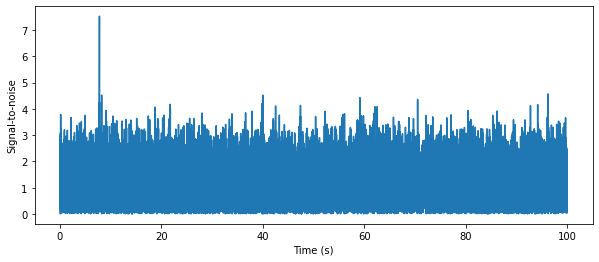

We found a signal at 7.787841796875s with SNR 7.527323078728172


In [0]:
from pycbc.filter import matched_filter

hp=signal
conditioned=final

hp.resize(len(conditioned))

template = hp.cyclic_time_shift(hp.start_time)
psd_whiten=interpolate(welch(final), 1.0 / final.duration)

snr = matched_filter(template, conditioned,
                     psd=psd_whiten, low_frequency_cutoff=20)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

# PSD Generation

In [0]:
from pycbc.psd.analytical import AdVDesignSensitivityP1200087,aLIGODesignSensitivityP1200087

In [0]:
psd=aLIGODesignSensitivityP1200087(f_samples, delta_f, low_freq_cutoff)

In [0]:
pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(1, 1024)
pylab.ylim(1e-48, 1e-45)
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('Strain^2 / Hz')
pylab.grid()

# Noise Generation

In [0]:
from pycbc.noise.gaussian import frequency_noise_from_psd

In [0]:
import numpy as np

In [0]:
noise=frequency_noise_from_psd(psd, seed=7)

In [0]:
pylab.loglog(psd.sample_frequencies,np.abs(noise)**2)
#pylab.loglog(psd.sample_frequencies,psd)
pylab.xlim(20, 1024)
#pylab.ylim(1e-48, 1e-45)
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('Strain^2 / Hz')
pylab.grid()

### Equivelantly in the time domain

In [0]:
noise_time = noise.to_timeseries()

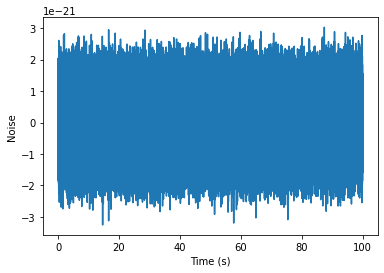

In [0]:
pylab.plot(noise.sample_times, noise)
pylab.ylabel('Noise')
pylab.xlabel('Time (s)')
pylab.show()

# Signal Generation

https://pycbc.org/pycbc/latest/html/waveform.html

In [0]:
from pycbc.waveform import get_td_waveform

apx = 'IMRPhenomD'
hp, hc = get_td_waveform(approximant=apx,
                                 mass1=30,
                                 mass2=30,
                                 spin1z=0,
                                 delta_t=1.0/8192,
                                 distance=2500,
                                 f_lower=20)


# pylab.plot(hp.sample_times, hp, label=apx)

# pylab.ylabel('Strain')
# pylab.xlabel('Time (s)')
# pylab.legend()
# pylab.show()

In [0]:
RA, dec, pol_angle[0]

(4.452922360003714, 0.4524999186594801, 3.0974511035662973)

In [0]:
from pycbc.detector import Detector
det_h1 = Detector('H1')
signal_h1 = det_h1.project_wave(hp, hc,  RA, dec, pol_angle[0])

In [0]:
signal_h1=signal

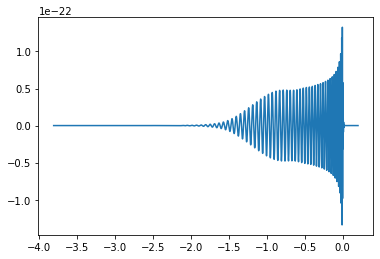

In [0]:
pylab.plot(signal_h1.sample_times, signal_h1)

In [0]:
signal_peak_index=np.argmax(signal_h1)

In [0]:
# signal_peak_time=signal_h1.sample_times[peak_index]


# Add Noise and Signal

In [0]:
# noise_mid=int(len(noise_time)/2)
length_signal = len(signal_h1)

In [0]:
noise_time=noise

In [0]:
signal_plus_noise=noise_time

In [0]:
# signal_plus_noise[noise_mid:noise_mid+length_signal]=np.add(noise_time[noise_mid:noise_mid+length_signal], signal_h1)
signal_plus_noise[0:length_signal]=np.add(noise_time[0:length_signal], signal_h1)

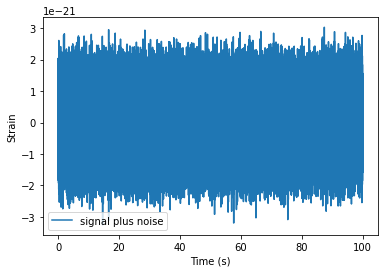

In [0]:
# pylab.plot(noise_time.sample_times, noise_time,label="noise" )
pylab.plot(signal_plus_noise.sample_times, signal_plus_noise, label="signal plus noise")
# pylab.plot(signal_h1.sample_times,  signal_h1, label="signal")

pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

In [0]:
signal

# Whiten the Noise

In [0]:
from pycbc.psd import welch, interpolate

In [0]:
# from pycbc.filter.resample import resample_to_delta_t
# signal_plus_noise_resampled = resample_to_delta_t(signal_plus_noise, 1/128)
signal_freq_series=signal_plus_noise.to_frequencyseries()

In [0]:
#numerator=np.abs(np.fft.fft(signal_frequecyseries)) #final_frequencies
numerator = signal_freq_series

In [0]:
psd_whiten = interpolate(welch(signal_plus_noise), 1.0 / signal_plus_noise.duration)

In [0]:
denominator=np.sqrt(psd_whiten)

In [0]:
whiten_freq = (numerator / denominator)

In [0]:
whiten=whiten_freq.to_timeseries()

In [0]:
# #whiten.sample_frequencies=whiten.sample_frequencies[np.logical_not(np.isnan(whiten.data))]
# whiten.data=whiten.data[np.logical_not(np.isnan(whiten.data))]
whiten.data

array([-64.38301343, -43.77437357, -19.09098838, ..., -32.72893584,
       -21.28192263,  12.03966786])

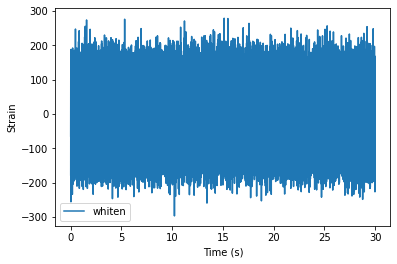

In [0]:
pylab.plot(whiten.sample_times, whiten, label='whiten')
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

# Zoom into 1s Data

In [0]:
signal_peak_index

31108

In [0]:
np.argmax(whiten), np.argmax(signal_plus_noise)

(123962, 126939)

In [0]:
max_index=signal_peak_index+2

In [0]:
time_of_max=whiten.sample_times.data[max_index]

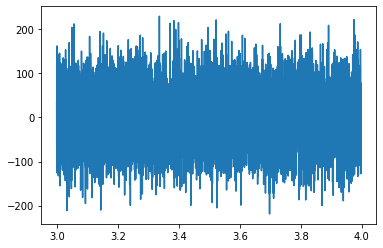

In [0]:
zoom = whiten.time_slice(time_of_max-0.8, time_of_max+0.2)
pylab.plot(zoom.sample_times, zoom)

In [0]:
test=np.zeros((1, 8192))
test=zoom.data

In [0]:
test

array([  36.33963647,  -62.74969946,   -2.70691959, ..., -127.63009389,
         27.98497743,  -55.53891513])

# LalSuite Inspinj

# Rough

In [0]:
# %matplotlib inline
# import pycbc.noise
# import pycbc.psd
# import pylab

# # Generate a PSD using an analytic expression for 
# # the full design Advanced LIGO noise curve
# f_lower = 10
# duration = 128
# sample_rate = 4096
# tsamples = sample_rate * duration
# fsamples = tsamples / 2 + 1
# df = 1.0 / duration
# psd = pycbc.psd.from_string('aLIGOZeroDetHighPower', fsamples, df, f_lower)

# # Let's take a look at the spectrum
# pylab.loglog(psd.sample_frequencies, psd)
# pylab.xlim(20, 1024)
# pylab.ylim(1e-48, 1e-45)
# pylab.xlabel('Frequency (Hz)')
# pylab.ylabel('Strain^2 / Hz')
# pylab.grid()

In [0]:
# htilde = pycbc.noise.frequency_noise_from_psd(psd, seed=857)

In [0]:
# pylab.loglog(psd.sample_frequencies,np.abs(htilde)**2)
# #pylab.loglog(psd.sample_frequencies,psd)
# pylab.xlim(20, 1024)
# #pylab.ylim(1e-48, 1e-45)
# pylab.xlabel('Frequency (Hz)')
# pylab.ylabel('Strain^2 / Hz')
# pylab.grid()

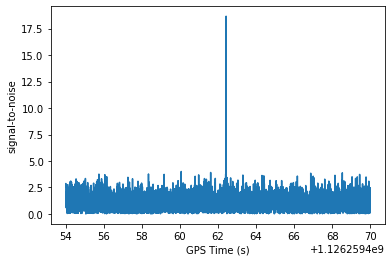

In [0]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, matched_filter
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
try:
    from urllib.request import urlretrieve
except ImportError:  # python < 3
    from urllib import urlretrieve

# Read data and remove low frequency content
fname = 'H-H1_LOSC_4_V2-1126259446-32.gwf'
url = "https://www.gw-openscience.org/GW150914data/" + fname
urlretrieve(url, filename=fname)
h1 = read_frame('H-H1_LOSC_4_V2-1126259446-32.gwf', 'H1:LOSC-STRAIN')
h1 = highpass_fir(h1, 15, 8)

# Calculate the noise spectrum
psd = interpolate(welch(h1), 1.0 / h1.duration)

# Generate a template to filter with
hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32,
                         f_lower=20, delta_f=1.0/h1.duration)
hp.resize(len(h1) // 2 + 1)

# Calculate the complex (two-phase SNR)
snr = matched_filter(hp, h1, psd=psd, low_frequency_cutoff=20.0)

# Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

import pylab
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise')
pylab.xlabel('GPS Time (s)')
pylab.show()


In [0]:
len(noise_time[i:i+length]), len(signal_h1)

(30, 32834)

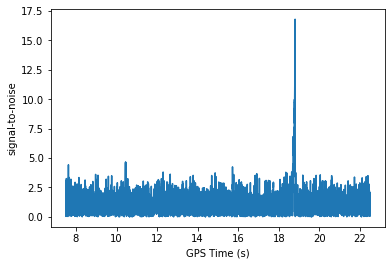

In [0]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, matched_filter
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
try:
    from urllib.request import urlretrieve
except ImportError:  # python < 3
    from urllib import urlretrieve

# Read data and remove low frequency content
#url = "https://www.gw-openscience.org/GW150914data/" + fname
#urlretrieve(url, filename=fname)
h1 = signal_plus_noise
#h1 = highpass_fir(h1, 15, 8)

# Calculate the noise spectrum
psd = interpolate(welch(h1), 1.0 / h1.duration)

# Generate a template to filter with
hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32,
                         f_lower=20, delta_f=1.0/h1.duration)
hp.resize(len(h1) // 2 + 1)

# Calculate the complex (two-phase SNR)
snr = matched_filter(hp, h1, psd=psd, low_frequency_cutoff=20.0)

# Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

import pylab
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise')
pylab.xlabel('GPS Time (s)')
pylab.show()

In [0]:
signal_plus_noise

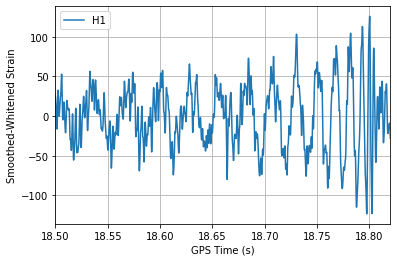

In [0]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.filter.resample import resample_to_delta_t
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab

for ifo in ['H1']:#, 'L1']:
    # Read data and remove low frequency content
    h1 = signal_plus_noise
    #h1 = highpass_fir(h1, 15, 8)

    # Calculate the noise spectrum
    psd = interpolate(welch(h1), 1.0 / h1.duration)

    # whiten
    white_strain = (h1.to_frequencyseries() / psd ** 0.5).to_timeseries()

    # remove some of the high and low
    smooth = highpass_fir(white_strain, 35, 8)
    smooth = lowpass_fir(white_strain, 300, 8)

    # time shift and flip L1
    if ifo == 'L1':
        smooth *= -1
        smooth.roll(int(.007 / smooth.delta_t))

    #smooth = resample_to_delta_t(smooth, 128)
    pylab.plot(smooth.sample_times, smooth, label=ifo)

pylab.legend()
pylab.xlim(18.5, 18.82)
#pylab.ylim(-150, 150)
pylab.ylabel('Smoothed-Whitened Strain')
pylab.grid()
pylab.xlabel('GPS Time (s)')
pylab.show()


In [0]:
low_freq_cutoff=0

In [0]:
psd1.data

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.19842845e-46, 3.19847879e-46, 0.00000000e+00])

/usr/local/lib/python3.6/dist-packages/pycbc/psd/analytical.py:103: RuntimeWarning: forcing length argument to int
  warnings.warn('forcing length argument to int', RuntimeWarning)


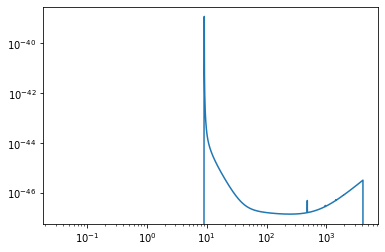

In [0]:
# pylab.plot(psd)
psd1=aLIGODesignSensitivityP1200087(f_samples, delta_f, low_freq_cutoff)
pylab.loglog(psd1.sample_frequencies, psd1)

In [0]:
psd.data

array([1.00179332e-53, 1.02660359e-53, 1.05141385e-53, ...,
       1.53145821e-46, 1.49505214e-46, 1.45864607e-46])

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


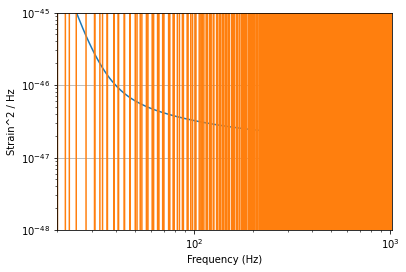

In [0]:
pylab.loglog(psd.sample_frequencies, psd)
pylab.loglog(psd.sample_frequencies, final_frequencies)
pylab.xlim(20, 1024)
pylab.ylim(1e-48, 1e-45)
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('Strain^2 / Hz')
pylab.grid()